In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted

%pip install plotly==5.9.0
%pip install twisted
%pip install pandas
%pip install ta    
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install matplotlib
%pip install scikeras
%pip install keras-tuner
%pip install plotly
%pip install nbformat
%pip install lightgbm
%pip install seaborn
    
#%pip install huobi-sdk==2.3.3

import pandas as pd
import numpy as np    
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
# Downloading latest pytrade2 data
#os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
data_dir=f"../data/dev/common"
#print(f"Download completed. Local data dir: {data_dir}")

In [2]:
symbol="BTC-USDT"
history_days=3
#test_size=2/history_days # 2 days
test_size = 0.2
features_periods = ['15min', '30min', '1h']
predict_window = '15min'

# 0.01*0.012*2 - open+close comission 0.012%
# Comission is 4.8 for 40K price, ~10 for one open+close trade
min_profit_ratio = (0.01*0.012*2) * 5
max_loss_ratio = (0.01*0.012*2) * 5
print(f'test size = {test_size}')

test size = 0.2


## Read candles history

In [3]:
from pathlib import Path

def read_candles(days = 1, period = '1min'):
    """ Read last days' 1 min candles from file system """

    candles_dir = Path(data_dir, 'candles')
    files = sorted([f for f in os.listdir(candles_dir) if f.endswith(f"candles_{period}.csv")])
    # Read last days' files to one dataframe
    df = pd.concat([pd.read_csv(Path(candles_dir, fname), parse_dates=['open_time', 'close_time']) for fname in files[-days:]])
    df = df.set_index('close_time', drop=False)
    #del(df['close_time.1']) # temp fix
    # Resample because row data contains multiple candles inside a period
    print(f'Read {len(df)} candles from {df.index.min()} to {df.index.max()}')
    return df.resample('1min').agg('last')

candles = read_candles(days=history_days)
candles.tail()

Read 4320 candles from 2023-12-30 00:01:00 to 2024-01-02 00:00:00


,close_time,open_time,ticker,interval,open,high,low,close,vol
close_time,,,,,,,,,
2024-01-01 23:56:00,2024-01-01 23:56:00,2024-01-01 23:55:00,BTC-USDT,1min,44206.9,44206.9,44198.0,44198.0,7384
2024-01-01 23:57:00,2024-01-01 23:57:00,2024-01-01 23:56:00,BTC-USDT,1min,44198.0,44211.0,44195.9,44195.9,6536
2024-01-01 23:58:00,2024-01-01 23:58:00,2024-01-01 23:57:00,BTC-USDT,1min,44195.9,44218.2,44195.9,44218.1,5358
2024-01-01 23:59:00,2024-01-01 23:59:00,2024-01-01 23:58:00,BTC-USDT,1min,44218.1,44245.0,44218.1,44244.9,3788
2024-01-02 00:00:00,2024-01-02 00:00:00,2024-01-01 23:59:00,BTC-USDT,1min,44250.8,44250.8,44215.5,44235.7,40540


## Calculate targets

In [4]:
import matplotlib.pyplot as plt

def plot_value_counts(ax, df, col, grouped):
    signals = df[col]
    #vc = signals[signals.diff() != 0].value_counts()
    vc = df[col].value_counts() if not grouped else signals[(signals.diff() != 0) & (signals != 0)].value_counts()
    label_map={0:'oom', 1:'buy', -1: 'sell'}
    color_map={'oom':'C0', 'buy': 'C1', 'sell': 'C2'}
    labels = [ label_map[signal] for signal in vc.index.tolist()]
    colors = [color_map[key] for key in labels]
    ax.pie(vc, labels = labels,  autopct= lambda x: '{:.0f}'.format(x*vc.sum()/100), colors = colors)
    tag = 'groups' if grouped else ''
    ax.set_title(f"{col} {tag}")
    
def plot_signal_counts(df):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    plot_value_counts(ax1, df, 'signal', grouped = False)
    plot_value_counts(ax2, df, 'signal', grouped = True)
    fig.suptitle(f'Signal counts from {df.index.min()} to {df.index.max()}')
    plt.show()

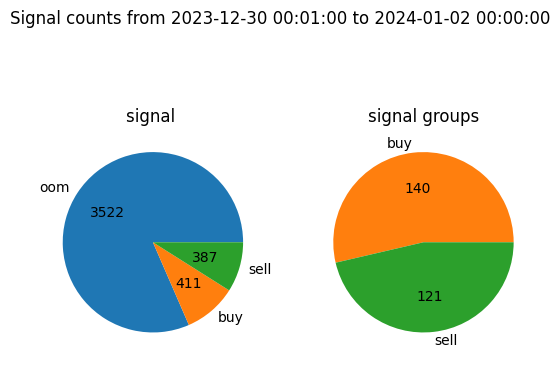

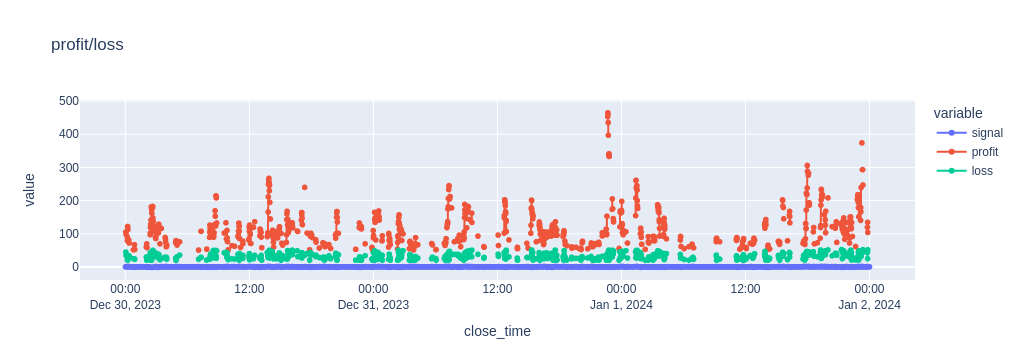

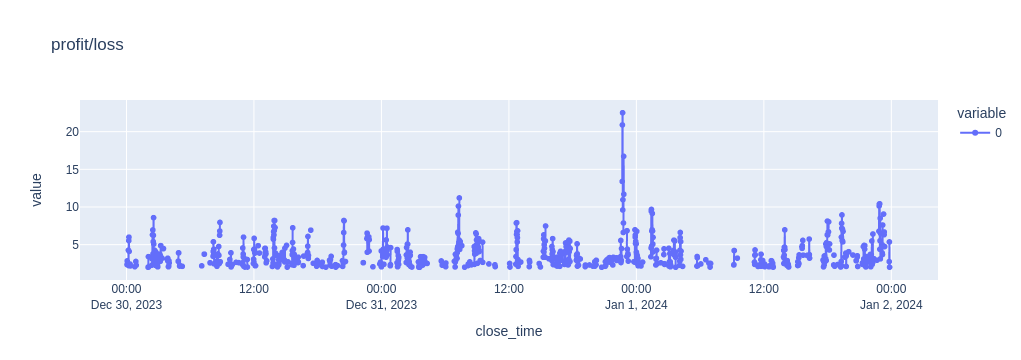

In [7]:

def calc_signal(candles, predict_window, open_ratio, min_profit_ratio, max_loss_ratio, comission_pct=0.012):
    """ Signal -1,0,1 plus extended debugging info """
    #next_candles = candles[['open', 'high', 'low', 'close', 'vol']].shift(1)

    next_candles = pd.DataFrame(index=candles.index)
    next_candles[['high', 'low']] = (candles[['high', 'low']][::-1]
                                     .rolling(predict_window).agg({'high' : 'max', 'low' : 'min'})
                                     [::-1])

    # BTC-USDT 40 000 * 1% = 400
    # BTC-USDT 40 000 * 0.012% = 40 * 0.012 = 4,8
    comission = comission_pct*0.01*2 # Order open, order close, double comission
    # Ratio to open: generate signal if profit/loss > open ratio
    #open_ratio = 1
    min_profit = candles['close']*(max(comission*2, min_profit_ratio))
    max_loss = candles['close']*max_loss_ratio
    
    signal = pd.DataFrame(index=candles.index)

    # Profit / loss > open ratio considering comission and minimal profit
    profit_buy = (next_candles['high'] - candles['high']) - (candles['close']*2*comission)
    loss_buy =  (candles['high'] - next_candles['low']) + (candles['close']*2*comission)
    signal_buy = (profit_buy > 0) & ((profit_buy / loss_buy) > open_ratio)& (profit_buy > min_profit) & (loss_buy < max_loss)

    
    # Profit / loss > open ratio considering comission and minimal profit
    profit_sell = (candles['low'] - next_candles['low']) - (candles['close']*2*comission)
    loss_sell = (next_candles['high'] - candles['low']) + (candles['close']*2*comission)
    signal_sell = (profit_sell > 0) & ((profit_sell / loss_sell) > open_ratio) & (profit_sell > min_profit) & (loss_sell < max_loss)

    # Signal
    signal['signal'] = 0  # Default to 0
    signal.loc[signal_buy & ~signal_sell, 'signal'] = 1  # Set to 1 where 'buy' is True and 'sell' is False
    signal.loc[~signal_buy & signal_sell, 'signal'] = -1  # Set to -1 where 'sell' is True and 'buy' is False

    df = signal
    # Future profit and loss
    df.loc[signal['signal']==1, 'profit'] = profit_buy
    df.loc[signal['signal']==1, 'loss'] = loss_buy
    df.loc[signal['signal']==-1, 'profit'] = profit_sell
    df.loc[signal['signal']==-1, 'loss'] = loss_sell


    return df

signal = (calc_signal(candles, 
                      predict_window = predict_window, 
                      open_ratio = 2, 
                      # 0.01*0.012*2 - open+close comission 0.012%
                      # Comission is 4.8 for 40K price, ~10 for one open+close trade
                      min_profit_ratio = min_profit_ratio,
                      max_loss_ratio = max_loss_ratio)
         )
#signal[signal['signal']!=0].tail(100)


# Pie plot, signals
plot_signal_counts(signal)


# Line plot, profit/loss
import plotly.express as px
import warnings
# Supress pandas+plotly warning
warnings.simplefilter(action='ignore', category=FutureWarning)
px.line(signal, title='profit/loss').update_traces(mode='lines+markers').show()

#profittoloss=(signal['profit']/signal['loss'])[signal['signal']!=0]
px.line((signal['profit']/signal['loss']), title='profit/loss').update_traces(mode='lines+markers').show()

# Matplotlib profit/loss chart
# signal[signal['signal']!=0].plot(linestyle=':', marker='o', title='profit/loss')
#plt.show()




## Feature engineering


### Calculate indicators

In [ ]:
from ta import trend, momentum, volume, others, volatility


def time_parts_of(candles: pd.DataFrame):
    # dt = df.index.to_frame()["close_time"].dt
    df = pd.DataFrame(index=candles.index)
    dt = df.index.astype('datetime64[ns]')
    df["time_hour"] = dt.hour
    df["time_minute"] = dt.minute
    return df

def ichimoku_of(candles: pd.DataFrame, period: str=''):
    df = pd.DataFrame()
    ichimoku = trend.IchimokuIndicator(candles['high'], candles['low'])
    df[f'ichimoku_base_line_{period}'] = ichimoku.ichimoku_base_line()
    df[f'ichimoku_conversion_line_{period}'] = ichimoku.ichimoku_conversion_line()
    df[f'ichimoku_a_{period}'] = ichimoku.ichimoku_a()
    df[f'ichimoku_b_{period}'] = ichimoku.ichimoku_b()    
    return df
    
def prev_candles_of(candles: pd.DataFrame, window_size):
    df = candles[["open", "high", "low", "close", "vol"]]
    cols = ["open", "high", "low", "close", "vol"]
    features = candles[cols].copy()
    # Add previous window candles to columns
    concat_features = [features]
    for i in range(1, window_size):
        prefix = f"-{i}_"
        prev_cols_map = {col: prefix + col for col in cols}
        prev_features = features[cols].shift(i).rename(prev_cols_map, axis=1)
        concat_features.append(prev_features)
    features = pd.concat(concat_features, axis=1).sort_index()

    # Add prefix to ohlcv columns
    # for col in cols:
    #     features.rename(columns={col: f"_{col}"}, inplace=True)

    return features.dropna()    

def indicators_of(candles, period):
    resampled = candles.resample(period).agg({'high':max, 'low':min, 'open': 'first', 'close': 'last', 'vol': sum})
    df = ichimoku_of(resampled, period)
    df[f'cci_{period}'] = trend.cci(resampled['high'], resampled['low'], resampled['close'])
    df[f'adx_{period}'] = trend.adx(resampled['high'], resampled['low'], resampled['close'])
    df[f'rsi_{period}'] = momentum.rsi(resampled['close'])
    df[f'stoch_{period}'] = momentum.stoch(resampled['high'], resampled['low'], resampled['close'])
    df[f'macd_{period}'] = trend.macd(resampled['close'])
    #df = features.dropna()
    return df
    
# Create time features and indicators
features = time_parts_of(candles)
#features = pd.concat([features] + [indicators_of(candles,period) for period in ['1min', '5min', '15min', '30min', '60min']], axis=1).ffill()
features = pd.concat([features] + [indicators_of(candles,period) for period in features_periods], axis=1).ffill()
features.tail()

In [ ]:
import plotly as py
from plotly import graph_objects as go
from plotly.subplots import make_subplots

def plot_indicators(candles, df, extra_lines:[], extra_subplots:[]):
    fig = make_subplots(rows=len(extra_subplots)+1, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.02,
                        subplot_titles=['candles']+extra_subplots
                       )    
    
    # Candles
    fig.add_trace(go.Candlestick(\
                        name='candles',
                        x=candles.index,\
                        open=candles['open'],\
                        high=candles['high'],\
                        low=candles['low'],\
                        close=candles['close'])
                     , row=1, col=1)

    # Other charts on candles chart
    for name in extra_lines:
        fig.add_trace(go.Scatter(name=name, x=df.index, y=df[name], mode='lines'), row=1, col=1)

    # Other subplots below candles
    for i, col in enumerate(extra_subplots):
        fig.add_trace(go.Scatter(name=col, x=df.index,y=df[col], mode='lines'), row=2+i, col=1)
    
    fig.update_layout(title=f"{candles['ticker'][0]}",
                    xaxis_rangeslider_visible=False, 
                    height=300*len(extra_subplots))
    fig.show()

suffix = f'_{min(features_periods)}'
ichimoku_cols = [f'ichimoku_base_line{suffix}', f'ichimoku_conversion_line{suffix}', f'ichimoku_a{suffix}', f'ichimoku_b{suffix}']
indicators_cols = [f'cci{suffix}', f'adx{suffix}', f'rsi{suffix}', f'stoch{suffix}']
plot_indicators(
            candles.tail(100),
            features.tail(100), 
             extra_lines=ichimoku_cols,
             extra_subplots=indicators_cols)


### Create features

In [ ]:
def balanced(features, targets):
    """ Balance by signal """
    targets = targets[['signal']]
    cnt = min(targets.value_counts())
    balanced_targets = pd.concat([targets[targets['signal'] == signal].sample(cnt) for signal in [-1,0,1]]).sort_index()
    balanced_features = features[features.index.isin(balanced_targets.index)].sort_index()
    return balanced_features, balanced_targets
    
    
def prepare_features(features, signal):
    """ Set diff cols ?? """

    #f = features.dropna()
    #t = signal.loc[f.index,['signal']]
    #return f,t
    f = features.dropna()
    t = signal[['signal']].dropna()
    ii = t.index.intersection(f.index)
    f,t = f.loc[ii,:], t.loc[ii,:]
    #diff_cols = [c for c in features.columns if not c.startswith('time_')]
    #f[diff_cols] = f[diff_cols].diff()
    return f,t


x, y = prepare_features(features, signal)
x, y = balanced(x, y)
plot_signal_counts(y[['signal']])

In [ ]:
import seaborn as sb
corr = features.corr()
kot = corr[corr.abs()>=.5]
#corr = corr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
# Plot the heatmap between features in the dataframe
sb.heatmap(corr, annot=False,
           cbar=True, cmap='RdBu', fmt='.1f')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer


def create_pipe(X, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in X.columns if col.startswith("time") or col.endswith("time")]
    float_cols = list(set(X.columns) - set(time_cols))

    # Scale x
    x_pipe = Pipeline(
        [
        ("xscaler", ColumnTransformer([("xrs", RobustScaler(), float_cols)], remainder="passthrough")),
        ("xmms", MinMaxScaler())])
    x_pipe.fit(X)

    # One hot encode y
    y_pipe = Pipeline([('adjust_labels', OneHotEncoder(categories=[[-1, 0, 1]], sparse_output=False, drop=None))])
    y_pipe.fit(y)
    return x_pipe, y_pipe


from sklearn.model_selection import train_test_split
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=test_size, shuffle=False)

x_pipe, y_pipe = create_pipe(x_train_df, y_train_df)
x_train = x_pipe.transform(x_train_df)
x_test = x_pipe.transform(x_test_df)
y_train = y_pipe.transform(y_train_df)
y_test = y_pipe.transform(y_test_df)

## Try keras model

In [ ]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
import plotly.express as px
import collections


plot_figsize=(10,5)

def create_models(*specs):
    results={}
    for unit_spec in specs:
        window_size=unit_spec[0]
        yield create_model(x_train, y_train, window_size, unit_spec[1:])

def create_model(x_train,  y_train, specs):
    """ Create model with layers given in specs """

    input_shape=(x_train.shape[1],)
    print(f"Creating model({specs}), input shape={input_shape}")

    model = Sequential()
    model.add(Input(shape=input_shape))

    # Keras layers
    for units in specs:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(y_train.shape[1], activation='softmax')) # Softmax for classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

def plot_history_plotly(df, title):
    px.line(df,title=title).update_traces(mode='lines+markers').show()
    
def plot_history_plt(df, title):
        plt.plot(df)
        #Captions and show the plot
        plt.title(title)
        plt.xlabel('epoch')
        plt.legend(df.columns)
        plt.show()    

def plot_history(model_name, history, plot_func, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        plt.figure(figsize=plot_figsize)
        title=f"{model_name} {metric_name}"
        names=[metric_name, f"val_{metric_name}"]
        
        df=pd.DataFrame()
        for name in names:
            df[name] = history.history[name]
        plot_func(df, title)

def evaluate_models(epochs=10, *specs):
    results={}
    for unit_spec in specs:
        model = create_model(x_train, y_train, unit_spec)
        
        #steps_per_epoch=200
        steps_per_epoch=max(1,x_train.shape[0]//epochs)+1
        history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=0)
        model_name = f"Model({unit_spec})"
        results[model_name] = history
    return results

def plot_res(results, plot_func):
    for model_name in results:
        plot_history(model_name, results[model_name], plot_func, 'categorical_accuracy')


        
# Good: Current LSTM2: 10, 320, 0.2, 160, 0.2, 40, 0.2, 16, 0.1
input_size = x_train.shape[1]
eval_res = evaluate_models(100, 
                                  [input_size],
                                  [input_size, input_size*4, 16],
                                  [input_size, input_size, input_size*4, 64,16]
                          )

plot_res(eval_res, plot_history_plt)

## Try lightdbm

In [ ]:
import lightgbm as lgb

def get_train_test_data(x, y):
    """ lgb train test """

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)
    y_train['signal'] = y_train['signal'] + 1
    y_test['signal'] = y_test['signal'] + 1

    float_cols = [col for col in x.columns if not col.startswith('time')]
    x_pipe = Pipeline([
        ("xscaler", ColumnTransformer([("xrs", RobustScaler(), float_cols)], remainder="passthrough")),
        ("xmms", MinMaxScaler())])
    x_train = x_pipe.fit_transform(x_train)
    x_test = x_pipe.transform(x_test)
    # Create LightGBM datasets
    train_data = lgb.Dataset(x_train, label=y_train)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    return train_data, test_data

train_data, test_data = get_train_test_data(x,y)


In [ ]:
def eval_lgb_model(train_data, test_data):
    # Defining parameters for the LightGBM
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': ['multi_logloss', 'multi_error'],
        'verbose': -1
    }
    rounds = 100
    evals = {}
    model = lgb.train(params,
                      train_data,
                      rounds,
                      valid_sets=[test_data],
                      callbacks = [lgb.record_evaluation(evals)]
                     )
    return model, evals
    

model, evals = eval_lgb_model(train_data, test_data)
for metrics in evals.values():
    for metric in metrics:
        lgb.plot_metric(evals, metric)

plt.show()

## Calculate test profit

In [ ]:
def calc_test_profit(x_test_df, y_test_df, model):
    x_test = x_pipe.transform(x_test_df)
    y_test = y_pipe.transform(y_test_df)
    # Predict
    y_actual = y_pipe.inverse_transform(model.predict(x_test))
    
    profit_data = y_test_df.copy()
    profit_data = profit_data.rename(columns={'signal' : 'signal_expected'})
    profit_data['signal_actual'] = y_actual
    profit_data = profit_data.join(candles['close'])
    
    bad_signal = profit_data['signal_expected'] != profit_data['signal_actual']
    signal_group_start = profit_data['signal_actual_group'] = profit_data['signal_actual'].diff() != 0
    
    profit_data['profit'] = 0
    profit_data.loc[bad_signal & signal_group_start, 'profit'] = -profit_data['close']*max_loss_ratio
    good_signal = (profit_data['signal_expected'] == profit_data['signal_actual']) & profit_data['signal_expected']
    profit_data.loc[good_signal & signal_group_start, 'profit'] = profit_data['close']*min_profit_ratio
    
    profit = sum(profit_data['profit'])
    return profit

profit =  calc_test_profit(x_test_df, y_test_df, model)
print(f'Test profit: {profit}')

profit =  calc_test_profit(x_train_df, y_train_df, model)
print(f'Train profit: {profit}')

